In [1]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ccee','#cc11ee','Ewert','Smokum',20,20
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

In [2]:
dhtml('Code Modules, Setting, & Functions')

In [3]:
import os,cv2,h5py,numpy as np,pandas as pd
import pylab as pl,seaborn as sn
import torch,tensorflow_hub as th,tensorflow as tf
import tensorflow.keras.preprocessing.image as kimg
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tqdm import tqdm
from PIL import Image,ImageFile
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
from IPython.core.magic import register_line_magic

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES=True
batch_size,batch_size2=12,10
img_size,img_size2=224,64
crop_size=(img_size2,img_size2)
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
fpath='../input/white-flowers/white_flowers/'
fpath2='../input/image-examples-for-mixed-styles/'
thpath='https://tfhub.dev/google/magenta/'+\
       'arbitrary-image-stylization-v1-256/1'
fw='weights.best.hdf5'
objects=['jasmine','phlox','leucanthemum maximum',
         'cherry','viola','lily of the valley',
         'apple tree','snowdrop','perennial aster',
         'blackberry','strawberry','Nanking cherry']
classes=['cherry','lily of the valley','snowdrop']

In [5]:
def path_to_tensor(img_path,fpath):
    img=kimg.load_img(fpath+img_path,
                      target_size=(img_size,img_size))
    x=kimg.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)/255
def load_img(path_to_img):
    max_dim=512
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img
def tensor_to_image(tensor):
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return Image.fromarray(tensor)
def premodel(img_size,dense,mh,num_classes,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((img_size,img_size,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(dense,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(num_classes,activation=activ)])
    model.compile(optimizer='adam',loss=loss,
                  metrics=['accuracy'])
    display(model.summary())
    return model
def cb(fw):
    early_stopping=\
    tkc.EarlyStopping(monitor='val_loss',
                      patience=5,verbose=2)
    checkpointer=\
    tkc.ModelCheckpoint(filepath=fw,verbose=2,
                        save_best_only=True)
    lr_reduction=\
    tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                          patience=3,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [6]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=classes[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()

In [7]:
dhtml('One Photo Processing')

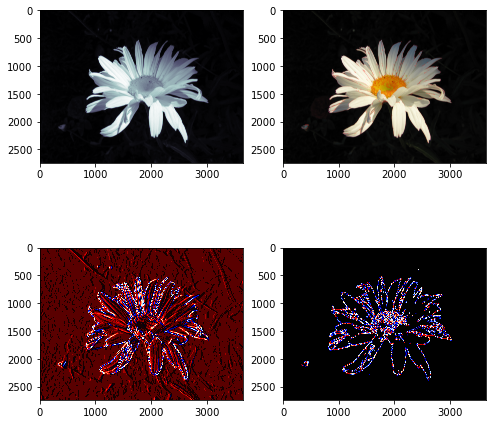

In [8]:
dhtml('opencv playing around',c2,f2,fs2)
img=cv2.imread(fpath+'03_004.png')
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
edge_img=img.copy()
edge=cv2.Canny(img_gray,20,120)
edge_img[edge!=0]=(255,0,0) 
sobel=cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=15)
pl.figure(figsize=(8,8))
pl.subplot(221),pl.imshow(img_gray,cmap='bone')
pl.subplot(222),pl.imshow(edge_img)
pl.subplot(223),pl.imshow(sobel,cmap='flag')
pl.subplot(224),pl.imshow(edge,cmap='flag_r')
pl.show()

40960/35363 [==================================] - 0s 0us/step
('matchstick', 0.07714511)
('nematode', 0.05730191)
('digital_clock', 0.031101355)
('lighter', 0.02672541)
('spotlight', 0.025922133)


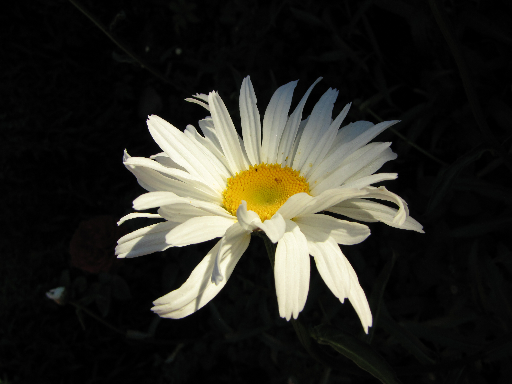

In [9]:
img=load_img(fpath+'03_004.png')
out=tf.keras.applications.vgg19\
.preprocess_input(img)
out=tf.image.resize(out,(224,224))
vgg19=tf.keras.applications\
.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg19(out)
predicted_top5=tf.keras.applications.vgg19\
.decode_predictions(prediction_probabilities.numpy())[0]
[print((class_name,prob))
 for (number,class_name,prob) in predicted_top5]
dhtml(':)))',c2,f2,fs2)
tensor_to_image(img)

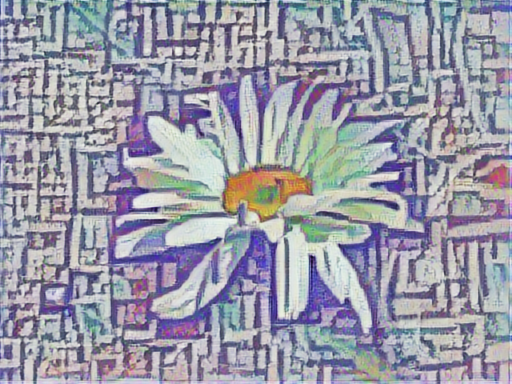

In [10]:
hub_module=th.load(thpath)  
content_image=load_img(fpath+'03_004.png')
style_image=load_img(fpath2+'pattern12.png')
stylized_image=hub_module(tf.constant(content_image),
                          tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [11]:
dhtml('Data Processing with <br/>'+\
      'Label Selection & Resizing')

In [12]:
num_classes=3
flist=sorted(os.listdir(fpath))
x=paths_to_tensor(flist,fpath)
y=np.array([int(el[:2]) for el in flist],
           dtype='int8')-1
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in y])
x=x[cond2]; y=y[cond2]
rd={3:0,5:1,7:2}
y=np.array([rd.get(el,el) for el in y],
            dtype='int8')
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(123).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]

100%|██████████| 359/359 [00:54<00:00,  6.58it/s]


In [13]:
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

,train,valid,test
0,"(184, 224, 224, 3)","(22, 224, 224, 3)","(22, 224, 224, 3)"
1,float32,float32,float32
2,"(184,)","(22,)","(22,)"
3,int8,int8,int8


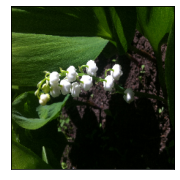

In [14]:
dhtml('label: %s'%classes[y_test[2]],c2,f2,fs2)
pl.figure(figsize=(3,3))
pl.xticks([]); pl.yticks([])
pl.imshow(x_test[2]);

In [15]:
with h5py.File('WhiteFlowerImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels',data=y_train)
    f.create_dataset('valid_images',data=x_valid)
    f.create_dataset('valid_labels',data=y_valid)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels',data=y_test)
st=['st_mode','st_ino','st_dev','st_nlink','st_uid',
    'st_gid','st_size','st_atime','st_mtime','st_ctime']
pd.DataFrame(os.stat('WhiteFlowerImages.h5'),
             index=st,columns=['os.stat results'])

,os.stat results
st_mode,33188
st_ino,131084
st_dev,1793
st_nlink,1
st_uid,0
st_gid,0
st_size,137285860
st_atime,1598949848
st_mtime,1598949848
st_ctime,1598949848


In [16]:
handle_base="mobilenet_v2_130_224"
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [17]:
model=premodel(img_size,3072,mhandle,num_classes,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,
                  batch_size=batch_size,epochs=7,
                  callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1664)              3766048   
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              5114880   
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9219      
Total params: 8,890,147
Trainable params: 8,845,891
Non-trainable params: 44,256
_________________________________________________________________


None

Epoch 1/7
16/16 [==============================] - ETA: 0s - loss: 0.7852 - accuracy: 0.8315
Epoch 00001: val_loss improved from inf to 4.90176, saving model to weights.best.hdf5
16/16 [==============================] - 32s 2s/step - loss: 0.7852 - accuracy: 0.8315 - val_loss: 4.9018 - val_accuracy: 0.8182
Epoch 2/7
16/16 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9674
Epoch 00002: val_loss did not improve from 4.90176
16/16 [==============================] - 30s 2s/step - loss: 0.2783 - accuracy: 0.9674 - val_loss: 13.9998 - val_accuracy: 0.7273
Epoch 3/7
16/16 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.9348
Epoch 00003: val_loss did not improve from 4.90176
16/16 [==============================] - 30s 2s/step - loss: 0.5165 - accuracy: 0.9348 - val_loss: 7.0778 - val_accuracy: 0.8636
Epoch 4/7
16/16 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.8478
Epoch 00004: val_loss improved from 4.90176 to 0.771

In [18]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 2ms/step - loss: 1.3213 - accuracy: 0.9545


[1.321282148361206, 0.9545454382896423]

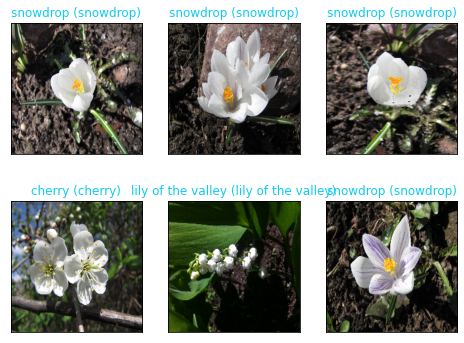

In [19]:
y_test_predict=np.argmax(model.predict(x_test),axis=-1)
fig=pl.figure(figsize=(8,6))
randch=np.random.choice(x_test.shape[0],
                        size=6,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title("{} ({})".format(classes[pred_idx],
                                  classes[true_idx]),
                 color=(c1 if pred_idx==true_idx 
                        else c2))
pl.show()

In [20]:
dhtml('Data Processing with <br/>'+\
      'Label Selection,Cropping, & Resizing')

In [21]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [22]:
shuffle_ids=np.arange(N)
np.random.RandomState(123).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
t1=tf.random.uniform(shape=(N,2),
                     minval=0,maxval=.2)
t2=tf.random.uniform(shape=(N,2),
                     minval=.8,maxval=1)
boxes=tf.concat([t1,t2],1)
box_indices=list(range(N))
x=tf.image\
.crop_and_resize(x,boxes,box_indices,crop_size)
x=np.transpose(x.numpy(),(0,3,1,2))
print(x.mean(),x.std())
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23
train=TData(x_train,y_train)
valid=TData(x_valid,y_valid)
test=TData(x_test,y_test)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size2), 
             'valid':tdl(dataset=valid,shuffle=True, 
                         batch_size=batch_size2),
             'test':tdl(dataset=test,shuffle=True, 
                        batch_size=batch_size2)}

0.3819334 0.27487445


Image dimensions: torch.Size([10, 3, 64, 64])
Label dimensions: torch.Size([10])


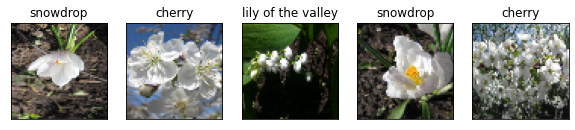

In [23]:
%display_examples valid

In [24]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [25]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [26]:
%train_run 15

Epoch: 001/015 | Batch: 000/019 | Cost: 1.2873
Epoch: 001/015 | Batch: 010/019 | Cost: 0.5949
Epoch: 001/015
train acc/loss: 95.65%/0.15 valid acc/loss: 95.45%/0.14
Epoch: 002/015 | Batch: 000/019 | Cost: 0.4418
Epoch: 002/015 | Batch: 010/019 | Cost: 0.3280
Epoch: 002/015
train acc/loss: 96.74%/0.09 valid acc/loss: 100.00%/0.06
Epoch: 003/015 | Batch: 000/019 | Cost: 0.0810
Epoch: 003/015 | Batch: 010/019 | Cost: 0.0979
Epoch: 003/015
train acc/loss: 99.46%/0.04 valid acc/loss: 100.00%/0.04
Epoch: 004/015 | Batch: 000/019 | Cost: 0.2375
Epoch: 004/015 | Batch: 010/019 | Cost: 0.4132
Epoch: 004/015
train acc/loss: 96.74%/0.06 valid acc/loss: 100.00%/0.02
Epoch: 005/015 | Batch: 000/019 | Cost: 0.0296
Epoch: 005/015 | Batch: 010/019 | Cost: 0.0153
Epoch: 005/015
train acc/loss: 97.83%/0.05 valid acc/loss: 100.00%/0.03
Epoch: 006/015 | Batch: 000/019 | Cost: 0.3227
Epoch: 006/015 | Batch: 010/019 | Cost: 0.1444
Epoch: 006/015
train acc/loss: 99.46%/0.02 valid acc/loss: 95.45%/0.07
Epoch:

In [27]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 100.00% || test acc: 100.00%


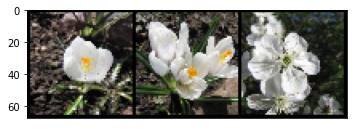

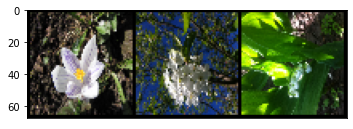

In [28]:
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:3]))
        st1='\ntrue labels: '+\
            ''.join('%20s'%classes[labels[j]] 
                    for j in range(3))
        dhtml(st1,c2,f2,fs2)
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,int(1))
        st2='\npredictions: '+\
            ''.join('%20s'%classes[preds[j]]
                    for j in range(3))
        dhtml(st2,c2,f2,fs2)
        if i==1: break